In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

In [4]:
data_path = os.getcwd() + "/dataset/raw_labelled/win_S01.csv"
# features = ["A_F", "A_V", "A_L", "L_F", "L_T", "L_L", "T_F", "T_V", "T_L"]

dataset = pd.read_csv(data_path)
time = list(dataset['time'])

TFdata = dataset[["T_F"]].values
TVdata = dataset[["T_V"]].values
TLdata = dataset[["T_L"]].values

dataframe = dataset[["T_F", "T_V", "T_L"]].values
dataset = dataset[["T_F", "T_V", "T_L", "Action"]].values

window_length = int(1*64)
total_windows = int((len(dataset))/window_length)

In [5]:
TFdata = np.array(TFdata)
TVdata = np.array(TVdata)
TLdata = np.array(TLdata)

In [6]:
Tsensor = np.multiply(TFdata, TFdata) + np.multiply(TVdata, TVdata) + np.multiply(TLdata, TLdata)
Tsensor = np.sqrt(Tsensor)

In [7]:
start = 21363
stop = 21683

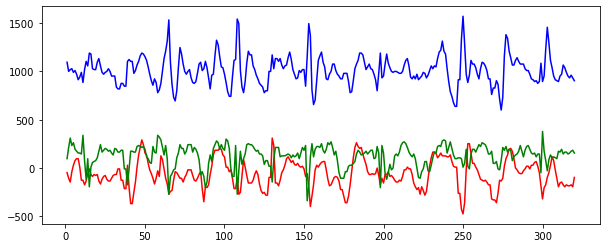

In [8]:
fig, ax = plt.subplots(figsize = (10, 4))
x = range(1, (stop-start+1))
y = TFdata[start:stop]

y1 = TVdata[start:stop]
y2 = TLdata[start:stop]
# y3 = Tsensor[start:stop]
# color = dataset.loc[20403:22003,"Action"]

plt.style.use("ggplot") 

plt.plot(x, y, 'r')
plt.plot(x, y1, 'b')
plt.plot(x, y2, 'g')
# plt.plot(x, y3, 'y')

In [9]:
TFdata = (TFdata-TFdata.mean())/TFdata.std()
TVdata = (TVdata-TVdata.mean())/TVdata.std()
TLdata = (TLdata-TLdata.mean())/TLdata.std()

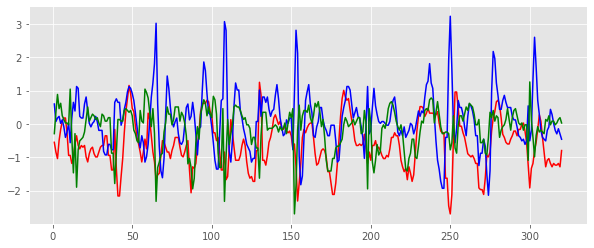

In [10]:
fig, ax = plt.subplots(figsize = (10, 4))
x = range(1, (stop-start+1))
y = TFdata[start:stop]

y1 = TVdata[start:stop]
y2 = TLdata[start:stop]
# color = dataset.loc[20403:22003,"Action"]

plt.style.use("ggplot") 

plt.plot(x, y, 'r')
plt.plot(x, y1, 'b')
plt.plot(x, y2, 'g')

In [11]:
from scipy.signal import butter, lfilter

In [12]:
b, a = butter(1,  0.8 , 'lowpass')

In [13]:
y = lfilter(b, a, TFdata[start:stop])
y1 = lfilter(b, a, TVdata[start:stop])
y2 = TVdata[start:stop]

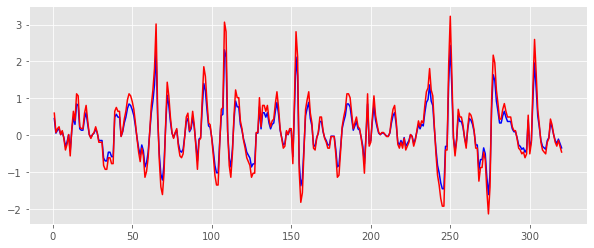

In [14]:
fig, ax = plt.subplots(figsize = (10, 4))

plt.style.use("ggplot") 

# plt.plot(x, y, 'r')
plt.plot(x, y1, 'b')
plt.plot(x, y2, 'r')

370.3703703703704


(array([ 0.5103  ,  1.5147  ,  2.5299  ,  3.5397  ,  4.5441  ,  5.5539  ,
         6.5772  ,  7.5951  ,  8.5887  ,  9.593101, 10.5948  , 11.5911  ,
        12.5901  , 13.6026  , 14.5881  , 15.5844  , 16.5807  , 17.5662  ,
        18.5598  , 19.5669  , 20.5551  , 21.5784  , 22.5639  , 23.5575  ,
        24.5322  , 25.5177  , 26.514   , 27.4995  , 28.4931  , 29.484   ]),
 array([ 0.081 ,  1.0989,  2.106 ,  3.1131,  4.1283,  5.1327,  6.1452,
         7.1712,  8.1729,  9.18  , 10.1763, 11.1753, 12.1743, 13.1814,
        14.1723, 15.1686, 16.1649, 17.1531, 18.1413, 19.1484, 20.142 ,
        21.1437, 22.1454, 23.1363, 24.1164, 25.1073, 26.1009, 27.0891,
        28.0692, 29.0736, 30.051 ]),
 array([ 0.    ,  1.0179,  2.025 ,  3.0348,  4.0473,  5.0436,  6.0615,
         7.0848,  8.0919,  9.0909, 10.0872, 11.1024, 12.0879, 13.1004,
        14.0967, 15.0795, 16.0785, 17.0694, 18.0603, 19.0593, 20.0583,
        21.0573, 22.0671, 23.0526, 24.0327, 25.0209, 25.9983, 27.0108,
        27.9909, 28.992

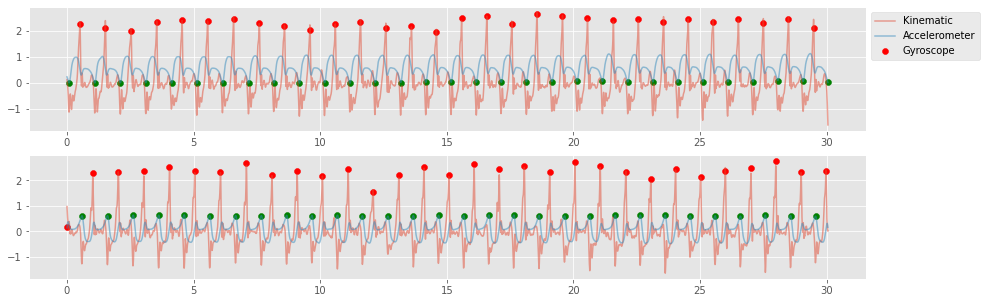

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

def FW(kinematic_file, IMU_file):

    # read kinematic and IMU data
    idata = pd.read_csv(IMU_file)

    # IMU data pre-processing:
    # heel accelerometer data: remove mean and apply low-pass filtering with 10 Hz threshold
    fi = idata['Time'].idxmax() / idata['Time'].max()
    print(fi)
    sos = signal.butter(1, 10, 'lp', fs = fi, output = 'sos')
    for j in [i for i in idata.columns if 'H.ACC' in i]:
        idata[j] = idata[j] - idata[j].mean() # remove mean
        idata[j] = signal.sosfilt(sos, idata[j]) # apply low-pass filter

    # heel gyroscope data: apply band-pass filter with 0.001 - 5 Hz thresholds.
    sos = signal.butter(1, (0.001,5), 'bp', fs = fi, output = 'sos')
    for j in [i for i in idata.columns if 'H.GY' in i]:
        idata[j] = signal.sosfiltfilt(sos, idata[j])


    # RHS: Right heel strike; RTO: Right toes off; LHS: Left heel strike; LTO: Left toes off

    # identify maxima (foot contacts) and minima (foot clearance) points from kinematic data
    n=50 # distance between data points. this number can me modified, depending on recording frequency

    # identify gait events from IMU data: maxima points of heel accelerometer as heel strikes, and minima points of
    # heel gyroscope as toes of.
    n=250
    idata['RHS'] = idata.iloc[signal.argrelextrema(signal.savgol_filter(idata['RH.ACC.Z'], 35, 2),
                                            np.greater_equal,
                                            order = n)[0]]['RH.ACC.Z']
    idata['RTO'] = idata.iloc[signal.argrelextrema(signal.savgol_filter(idata['RH.GY.Z'].values, 51, 3),
                                            np.less_equal,
                                            order = n)[0]]['RH.GY.Z']
    idata['LHS'] = idata.iloc[signal.argrelextrema(signal.savgol_filter(idata['LH.ACC.Z'].values, 35, 2),
                                            np.greater_equal,
                                            order = n)[0]]['LH.ACC.Z']
    idata['LTO'] = idata.iloc[signal.argrelextrema(signal.savgol_filter(idata['LH.GY.Z'].values,51,3), # notice reversing of gyroscope data
                                            np.greater_equal,
                                            order = n)[0]]['LH.GY.Z']

    # display kinematic, accelerometer and gyroscope data, with identified gait events
    plt.figure (figsize = (15, 5))
    plt.subplot(2,1,1)
    plt.plot(idata['Time'], signal.savgol_filter(idata['RH.ACC.Z'], 35, 2), alpha = 0.5)
    plt.plot(idata['Time'], signal.savgol_filter(idata['RH.GY.Z'] / 600, 51, 3), alpha = 0.5) # gyroscope data i recuded to fit in graph
    plt.scatter(idata['Time'], idata['RHS'],color = 'red')
    plt.scatter(idata['Time'], idata['RTO'] / 600,color = 'green')
    plt.legend(['Kinematic','Accelerometer','Gyroscope'],bbox_to_anchor = (1,1))

    plt.subplot(2,1,2)
    plt.plot(idata['Time'], signal.savgol_filter(idata['LH.ACC.Z'], 35, 2), alpha = 0.5)
    plt.plot(idata['Time'], signal.savgol_filter(idata['LH.GY.Z'] / 600, 51, 3), alpha = 0.5) # gyroscope data i recuded to fit in graph
    plt.scatter(idata['Time'], idata['LHS'],color = 'red')
    plt.scatter(idata['Time'], idata['LTO'] / 600,color = 'green')


    # return eight arrays:  right kinematic-based foot contacts times, right kinematic-based foot clearance times,
    #                       left kinematic-based foot contacts times, left kinematic-based foot clearance times,
    #                       right IMU-based foot contacts times, right IMU-based foot clearance times,
    #                       left IMU-based foot contacts times and left IMU-based foot clearance times

    return (
            idata[['Time','RHS']].dropna()['Time'].values, idata[['Time','RTO']].dropna()['Time'].values,
            idata[['Time','LHS']].dropna()['Time'].values, idata[['Time','LTO']].dropna()['Time'].values)



FW(kinematic_file = 'FW Kinematic data (example).csv', IMU_file = 'FW IMU data (example).csv')
